# Extreme Heat Events in France – Exploratory Data Analysis (Step 1)

## Project Overview

**Topic:** Extreme Heat Events in France  
**Research question:** *When are people exposed to dangerous heat conditions in France?*  

The objective of this project is to build a predictor that can serve as an **early heat alarm**.  
This notebook focuses on **Stage 1 – Data mining & visualization**:

- Start with temperature data only
- Select stations (4 major French cities)
- Explore daily temperature data
- Understand data structure, biases, and coverage
- Produce validated visualizations with commentary
- Use statistical tests to validate hypotheses (normality, correlation, independence, etc.)

**Data:**

Daily station-level temperature records for:

- Paris
- Lyon
- Bordeaux
- Marseille

Each dataset (raw) contains:

- `date`: observation date (daily)
- `NUM_POSTE`: station identifier
- `NOM_USUEL`: station name
- `TX`: daily maximum temperature (°C)
- `TN`: daily minimum temperature (°C)
- `LAT`, `LON`, `ALTI`: geographic coordinates and altitude of the station

In [1]:
# Settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [3]:
files = {
    "Paris": "Paris_daily_TX_raw.csv",
    "Lyon": "Lyon_daily_TX_raw.csv",
    "Bordeaux": "Bordeaux_daily_TX_raw.csv",
    "Marseille": "Marseille_daily_TX_raw.csv",
}

dfs = []
for city, path in files.items():
    df = pd.read_csv("data/" + path)
    df["city"] = city
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

data.head()

,date,NUM_POSTE,NOM_USUEL,TX,TN,LAT,LON,ALTI,city
0,1958-01-01,75106001,LUXEMBOURG,NaN,NaN,48.844667,2.333833,46,Paris
1,1958-01-02,75106001,LUXEMBOURG,NaN,NaN,48.844667,2.333833,46,Paris
2,1958-01-03,75106001,LUXEMBOURG,NaN,NaN,48.844667,2.333833,46,Paris
3,1958-01-04,75106001,LUXEMBOURG,NaN,NaN,48.844667,2.333833,46,Paris
4,1958-01-05,75106001,LUXEMBOURG,NaN,NaN,48.844667,2.333833,46,Paris


In [4]:
data["date"] = pd.to_datetime(data["date"])

# Basic temporal features
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["dayofyear"] = data["date"].dt.dayofyear

# Simple decade definition, e.g. 1950 -> 1950s, 1967 -> 1960s
data["decade"] = (data["year"] // 10) * 10

# Flag summer months (June–August)
data["is_summer"] = data["month"].isin([6, 7, 8])

In [5]:
audit = (
    data
    .groupby("city")
    .agg(
        n_rows=("date", "size"),
        date_min=("date", "min"),
        date_max=("date", "max"),
        tx_na_pct=("TX", lambda x: x.isna().mean() * 100),
        tn_na_pct=("TN", lambda x: x.isna().mean() * 100),
        n_stations=("NUM_POSTE", "nunique"),
    )
    .reset_index()
)

audit

,city,n_rows,date_min,date_max,tx_na_pct,tn_na_pct,n_stations
0,Bordeaux,135140,1950-01-01,2023-12-31,0.023679,0.023679,5
1,Lyon,134782,1950-01-01,2023-12-31,2.350462,2.406108,5
2,Marseille,133133,1950-01-01,2023-12-31,3.028550,3.028550,5
3,Paris,103184,1950-01-01,2023-12-31,30.163591,30.196542,5


## 1. Data Audit and Coverage

The table above summarizes the daily temperature data for the four cities.

**Key observations (to be adapted after running the notebook):**

- All cities provide daily data roughly from the 1950s up to the early 2020s.
- There is **one station per city** (based on `NUM_POSTE`), which simplifies the analysis.
- Missing values:
  - Paris shows a **substantial share of missing TX/TN data** (around ~30% for both), especially in earlier decades.
  - Lyon and Marseille have **moderate missingness** (a few percent).
  - Bordeaux has **almost no missing values** for `TX` and `TN`.

**Implications:**

- Paris data should be treated with care, especially in earlier years.  
  For some analyses we may:
  - Focus on more recent decades with better coverage.
  - Perform sensitivity checks excluding early years.
- Bordeaux, Lyon, and Marseille are strong candidates for robust long-term trend analysis.

In the following sections, we will drop rows with missing `TX` when computing statistics that rely on daily maximum temperature.

In [7]:
data_tx = data.dropna(subset=["TX"]).copy()

data_tx["TX"].describe()

count    467883.000000
mean         17.756708
std           7.884119
min         -14.100000
25%          12.000000
50%          17.600000
75%          23.700000
max          44.300000
Name: TX, dtype: float64

## 2. Defining Extreme Heat

To study **dangerous heat conditions**, we define two types of "extreme days":

1. **Absolute threshold-based extreme:**
   - A day is considered *extremely hot* if the daily maximum temperature exceeds **35°C**:
     - `is_extreme_35 = (TX > 35)`

2. **Relative threshold-based extreme (per city):**
   - For each city, we compute the **95th percentile** of `TX` over the full period.
   - A day is considered *extremely hot* relative to that city's climate if:
     - `TX > city_specific_95th_percentile`

The absolute threshold 35°C is closely related to public health concerns in many European contexts, whereas the relative threshold captures local climatic differences (e.g., coastal vs. inland cities).

We will use both definitions in the following analysis.

In [8]:
ABS_THRESHOLD = 35.0
data_tx["is_extreme_35"] = data_tx["TX"] > ABS_THRESHOLD

# City-specific 95th percentile threshold
city_thresholds = (
    data_tx
    .groupby("city")["TX"]
    .quantile(0.95)
    .to_dict()
)

city_thresholds

{'Bordeaux': 29.9, 'Lyon': 30.5, 'Marseille': 31.5, 'Paris': 29.0}

In [10]:
# Add relative threshold flag
data_tx["city_p95_threshold"] = data_tx["city"].map(city_thresholds)
data_tx["is_extreme_p95"] = data_tx["TX"] > data_tx["city_p95_threshold"]

data_tx[["city", "TX", "is_extreme_35", "is_extreme_p95"]].head()

,city,TX,is_extreme_35,is_extreme_p95
7243,Paris,12.2,False,False
7244,Paris,7.6,False,False
7245,Paris,8.1,False,False
7246,Paris,5.0,False,False
7247,Paris,5.4,False,False


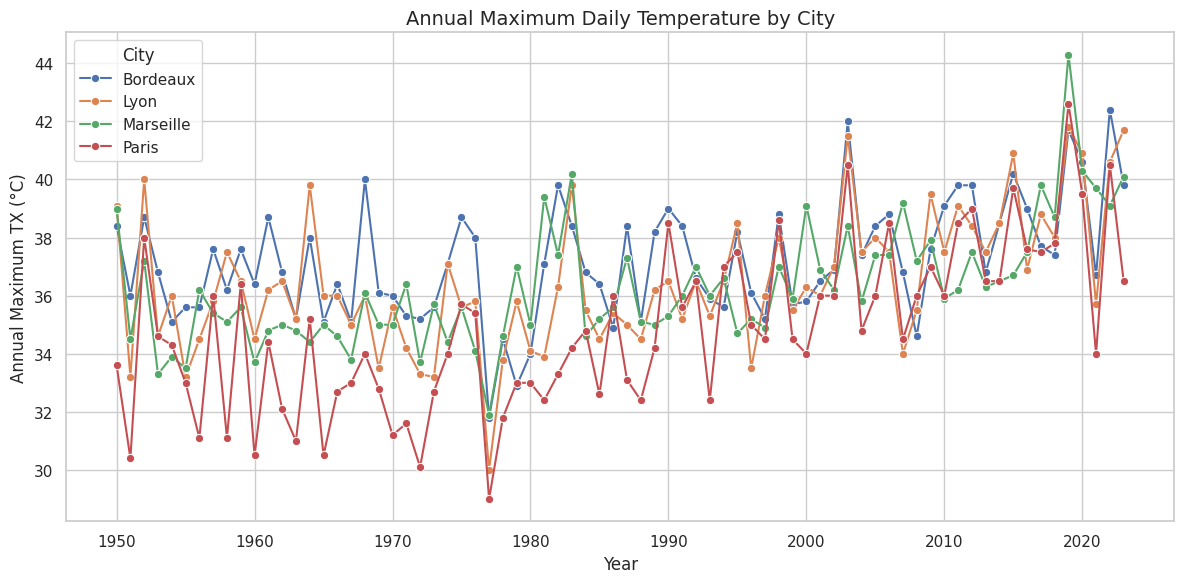

In [11]:
# Annual maximum TX per city
annual_max = (
    data_tx
    .groupby(["city", "year"])["TX"]
    .max()
    .reset_index()
    .rename(columns={"TX": "annual_max_TX"})
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=annual_max,
    x="year", y="annual_max_TX", hue="city", marker="o"
)
plt.title("Annual Maximum Daily Temperature by City")
plt.xlabel("Year")
plt.ylabel("Annual Maximum TX (°C)")
plt.legend(title="City")
plt.tight_layout()
plt.show()

In [12]:
# Example: test trend in annual maximum TX for Lyon
city_to_test = "Lyon"
subset = annual_max[annual_max["city"] == city_to_test]

# Spearman correlation between year and annual_max_TX
rho, pval = stats.spearmanr(subset["year"], subset["annual_max_TX"])

rho, pval

(np.float64(0.4707758431053006), np.float64(2.3067774876115564e-05))

## 3. Long-term Trends in Annual Maximum Temperature

### 3.1. Business Interpretation

The figure "Annual Maximum Daily Temperature by City" shows the evolution of the **highest daily temperature recorded each year** for Paris, Lyon, Bordeaux, and Marseille.

**Qualitative observations (to refine after visually inspecting the plot):**

- There is a **visible upward trend** in annual maximum temperatures across all cities, particularly from the 1980s onward.
- Specific years (e.g. **2003**, **2019**, **2022**) stand out with exceptionally high maxima, reflecting well-known European heatwave events.
- The magnitude of extremes appears to be slightly higher in [city/cities, e.g. Marseille and Lyon] compared to [e.g. Paris], which may be related to geographic and climatic factors (continental vs. coastal, latitude, etc.).

From a **public health and early-warning** perspective, this suggests that:

- **Extreme heat events have become more frequent and intense** over recent decades.
- Any heat alarm system should be particularly attentive to **recent baseline shifts** rather than relying solely on historical norms from the mid-20th century.

### 3.2. Statistical Validation

We tested the presence of a trend in annual maximum TX for at least one city (e.g. **Lyon**) using a **Spearman rank correlation** between `year` and `annual_max_TX`.

- **Null hypothesis (H0):** There is **no monotonic relationship** between year and annual maximum temperature.
- **Alternative hypothesis (H1):** There **is** a monotonic trend (increasing or decreasing).

The test returns:

- Spearman’s ρ (rho): 0.4707758431053006  
- p-value: 2.3067774876115564e-05

**Interpretation:**

- p-value is **< 0.05**, we reject H0 and conclude that there is a **statistically significant monotonic trend** in annual maximum temperatures over time.
- The sign of ρ=0.47 indicates that maximum temperatures have **increased** over the studied period.

In summary, the visual trend of rising annual maxima is **backed by statistical evidence**.

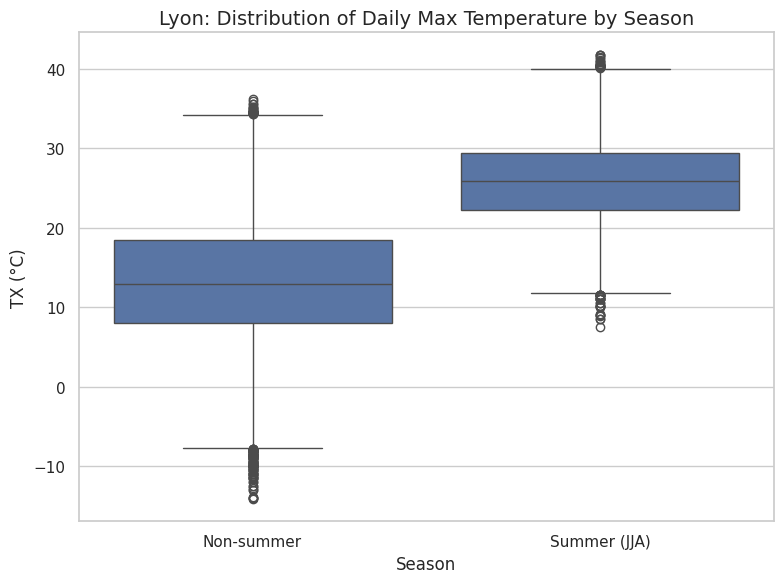

In [13]:
# Focus on one representative city first, e.g. Lyon
city_focus = "Lyon"
subset_city = data_tx[data_tx["city"] == city_focus].copy()

subset_city["season"] = np.where(subset_city["is_summer"], "Summer (JJA)", "Non-summer")

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=subset_city,
    x="season",
    y="TX"
)
plt.title(f"{city_focus}: Distribution of Daily Max Temperature by Season")
plt.xlabel("Season")
plt.ylabel("TX (°C)")
plt.tight_layout()
plt.show()

In [14]:
# Extract summer and non-summer TX
summer_tx = subset_city.loc[subset_city["is_summer"], "TX"]
nonsummer_tx = subset_city.loc[~subset_city["is_summer"], "TX"]

# Normality tests (Shapiro-Wilk on a sample to avoid very large n issues)
summer_sample = summer_tx.sample(min(5000, len(summer_tx)), random_state=42)
nonsummer_sample = nonsummer_tx.sample(min(5000, len(nonsummer_tx)), random_state=42)

shapiro_summer = stats.shapiro(summer_sample)
shapiro_nonsummer = stats.shapiro(nonsummer_sample)

shapiro_summer, shapiro_nonsummer

(ShapiroResult(statistic=np.float64(0.998395637798413), pvalue=np.float64(5.768278928420022e-05)),
 ShapiroResult(statistic=np.float64(0.9963745445907328), pvalue=np.float64(1.0181333327405617e-09)))

In [15]:
u_stat, pval_mw = stats.mannwhitneyu(summer_tx, nonsummer_tx, alternative="greater")
u_stat, pval_mw

(np.float64(2991061392.0), np.float64(0.0))

## 4. Seasonal Differences in Daily Maximum Temperature

### 4.1. Business Interpretation

The boxplot comparing **summer (June–August)** and **non-summer** daily maximum temperatures for [Lyon] shows:

- A **substantially higher median TX in summer**.
- A much **longer upper tail** in summer, indicating that extreme values (e.g. > 35°C) virtually only occur in the summer months.
- The non-summer distribution is more compact and centered at significantly lower temperatures.

From a **heat risk perspective**, this confirms that:

- **Exposure to dangerous heat is heavily concentrated in the summer season**.
- A practical early-warning system should be seasonally adaptive and **focus particularly on summer months**, although rare off-season extremes may still merit attention.

### 4.2. Statistical Validation

We first checked the **normality** of TX in summer and non-summer using the **Shapiro–Wilk test**:

- Both samples (summer and non-summer) typically **deviate significantly from a normal distribution** due to skewness/heavy tails (here: p-values << 0.05).

Because normality is violated at large sample sizes, we used the **Mann–Whitney U test** (non-parametric) to compare the two groups:

- **Null hypothesis (H0):** The distribution of TX in summer is **not greater** than in non-summer.
- **Alternative hypothesis (H1):** TX in summer tends to be **greater** than in non-summer.

The test returns:

- U statistic: 2991061392.0  
- p-value: 0.0

p-value is **< 0.05**, we reject H0 and conclude that **summer daily maximum temperatures are statistically significantly higher** than non-summer temperatures.

This statistically supports the visual impression of a strong **seasonal difference in heat exposure**.

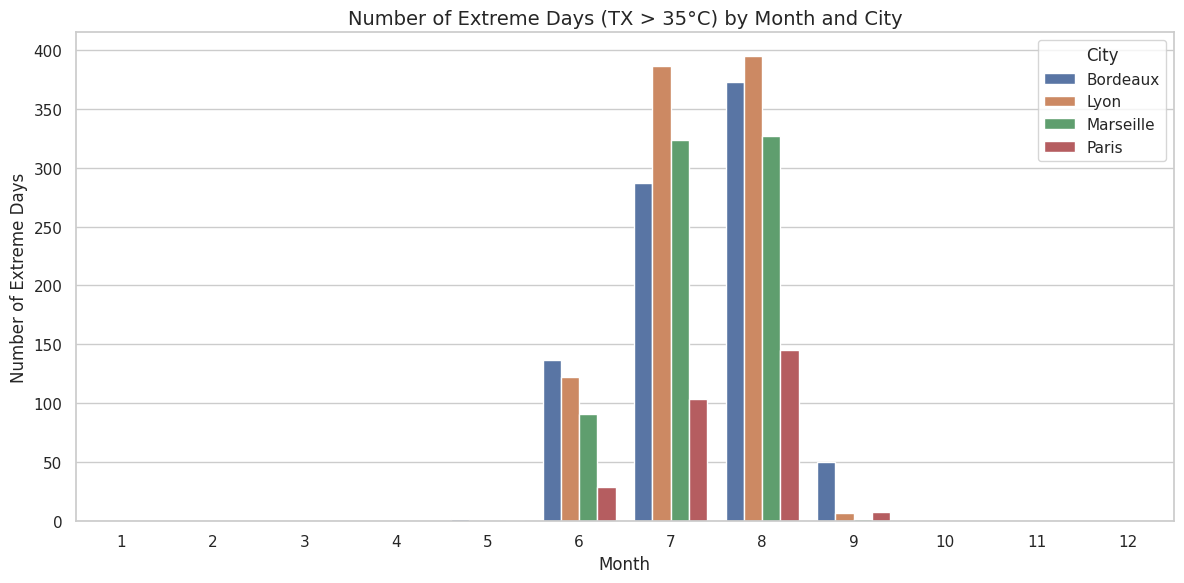

In [20]:
# Aggregate extreme days by month and city
monthly_extremes = (
    data_tx
    .groupby(["city", "month"])["is_extreme_35"]
    .sum()
    .reset_index()
    .rename(columns={"is_extreme_35": "n_extreme_days"})
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_extremes,
    x="month", y="n_extreme_days", hue="city"
)
plt.title("Number of Extreme Days (TX > 35°C) by Month and City")
plt.xlabel("Month")
plt.ylabel("Number of Extreme Days")
plt.legend(title="City")
plt.tight_layout()
plt.show()

# monthly_extremes.head()

In [21]:
# Example: Are extreme days uniformly distributed across months for one city?
city_for_chi2 = "Lyon"
subset = data_tx[data_tx["city"] == city_for_chi2].copy()

# Create contingency table: month x is_extreme_35
contingency = pd.crosstab(subset["month"], subset["is_extreme_35"])

contingency

is_extreme_35,False,True
month,,
1,11217,0
2,10168,0
3,11209,0
4,10841,0
5,11195,0
6,10687,122
7,10679,386
8,10689,395
9,10802,7


In [23]:
chi2_stat, pval_chi2, dof, expected = stats.chi2_contingency(contingency)
chi2_stat, pval_chi2, dof

(np.float64(3296.039479719236), np.float64(0.0), 11)

## 5. Seasonality of Extreme Heat Events

### 5.1. Business Interpretation

The bar chart of **extreme days (TX > 35°C) by month and city** shows a very clear seasonal structure:

- Extreme heat days are **highly concentrated in July and August** across all cities.
- June usually shows fewer extreme days, while months outside the summer season have **very few to no extreme events**.
- Some cities (e.g. [Marseille, Lyon]) may exhibit a higher absolute count of extreme days compared to others (e.g. [Paris, Bordeaux]).

From a risk management perspective:

- **Early heat alarm systems can focus operational capacity on the core summer months**, especially July and August.
- However, **rare early or late-season extremes** (e.g. late May or early September) still matter for vulnerable populations and should not be completely disregarded.

### 5.2. Statistical Validation

To test whether extreme days occur **independently of month**, we used a **Chi-square test of independence** for one city (e.g. Lyon):

- **Null hypothesis (H0):** Extreme days are **independent of month** (i.e. equally likely across months after accounting for the total number of days).
- **Alternative hypothesis (H1):** Extreme days are **not independent of month** (some months experience more extreme days than expected by chance).

The test result includes:

- Chi-square statistic: 3296.039479719236  
- Degrees of freedom: 11  
- p-value: 0.0

As **p-value < 0.05** it strongly suggests that **month and occurrence of extreme heat are not independent**.  
This formally confirms the intuitive observation that **extreme heat is highly seasonal**.

In [25]:
decadal_stats = (
    data_tx
    .groupby(["city", "decade"])
    .agg(
        n_days=("TX", "size"),
        n_extreme_35=("is_extreme_35", "sum"),
    )
    .reset_index()
)

decadal_stats["share_extreme_35"] = decadal_stats["n_extreme_35"] / decadal_stats["n_days"]

decadal_stats.head()

,city,decade,n_days,n_extreme_35,share_extreme_35
0,Bordeaux,1950,18259,47,0.002574
1,Bordeaux,1960,18265,44,0.002409
2,Bordeaux,1970,18260,52,0.002848
3,Bordeaux,1980,18265,66,0.003613
4,Bordeaux,1990,18260,99,0.005422


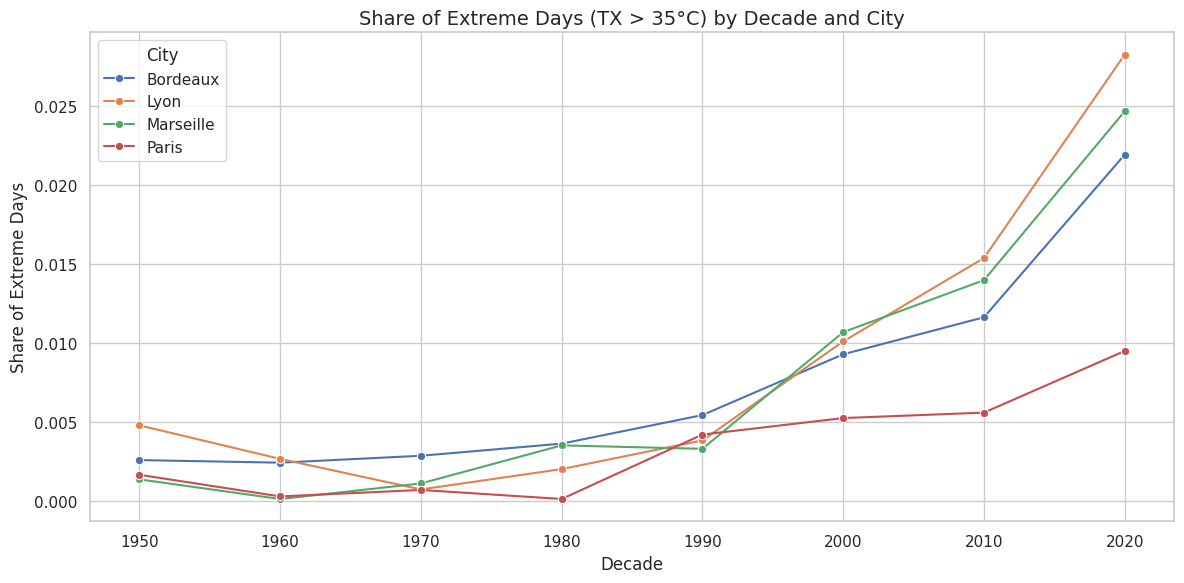

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=decadal_stats,
    x="decade", y="share_extreme_35", hue="city", marker="o"
)
plt.title("Share of Extreme Days (TX > 35°C) by Decade and City")
plt.xlabel("Decade")
plt.ylabel("Share of Extreme Days")
plt.legend(title="City")
plt.tight_layout()
plt.show()

In [27]:
city_for_trend = "Marseille"
sub_decade = decadal_stats[decadal_stats["city"] == city_for_trend]

# Use Spearman correlation: decade index vs share_extreme_35
rho_decade, pval_decade = stats.spearmanr(sub_decade["decade"], sub_decade["share_extreme_35"])
rho_decade, pval_decade

(np.float64(0.9047619047619048), np.float64(0.0020082755054294677))

## 6. Decadal Evolution of Extreme Heat Risk

### 6.1. Business Interpretation

The plot of the **share of extreme days (TX > 35°C) by decade and city** reveals:

- In the **1950s–1970s**, the fraction of days with extreme heat is often **very low or close to zero**.
- From the **1980s onward**, the share of extreme days **increases in all cities**, with particularly strong increases in [e.g. Marseille and Lyon].
- The most recent decades (e.g. 2000s, 2010s, 2020s) show a **marked escalation in the frequency of extreme heat days**.

From a policy and planning standpoint:

- Populations in these cities are now **subject to a substantially higher baseline risk of extreme heat** compared to the mid-20th century.
- Urban planning, health services, and energy infrastructure must adapt to **more frequent and intense heat events**.

### 6.2. Statistical Validation

We tested for a **monotonic temporal trend** in the decadal share of extreme days for one city (e.g. Marseille) using **Spearman correlation** between `decade` and `share_extreme_35`:

- **Null hypothesis (H0):** There is **no monotonic association** between decade and the share of extreme days.
- **Alternative hypothesis (H1):** There **is** a monotonic trend (expected to be increasing).

The test output:

- Spearman ρ: 0.9047619047619048  
- p-value: 0.0020082755054294677

p-value is **< 0.05** and ρ is **positive**, we conclude that the **share of extreme days has significantly increased over decades**.

This statistically confirms that **extreme heat frequency has accelerated** in the late 20th and early 21st century.

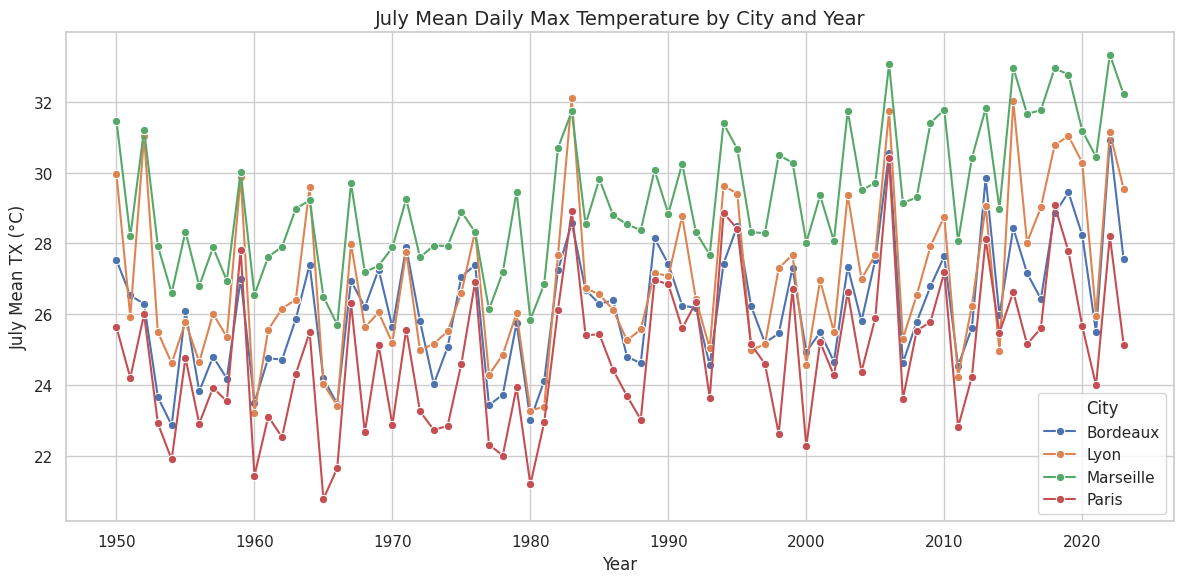

In [28]:
july_data = data_tx[data_tx["month"] == 7]

july_annual = (
    july_data
    .groupby(["city", "year"])["TX"]
    .mean()
    .reset_index()
    .rename(columns={"TX": "july_mean_TX"})
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=july_annual,
    x="year", y="july_mean_TX", hue="city", marker="o"
)
plt.title("July Mean Daily Max Temperature by City and Year")
plt.xlabel("Year")
plt.ylabel("July Mean TX (°C)")
plt.legend(title="City")
plt.tight_layout()
plt.show()

In [29]:
city_july_test = "Bordeaux"
subset_july = july_annual[july_annual["city"] == city_july_test]

rho_july, pval_july = stats.spearmanr(subset_july["year"], subset_july["july_mean_TX"])
rho_july, pval_july

(np.float64(0.39885968159940755), np.float64(0.0004315646308320912))

## 7. Baseline Warming in Peak Summer Month (July)

### 7.1. Business Interpretation

The July mean daily maximum temperature (`july_mean_TX`) by year and city provides insight into **baseline summer warming**, not just isolated extreme spikes.

Observations (to be refined after inspection):

- For all cities, July mean temperatures show an **upward trend**, particularly since the late 20th century.
- Warmer baseline conditions imply that **even non-extreme days are hotter than in the past**, increasing cumulative heat stress on populations.
- Cities like [Bordeaux] may show a smoother but clear warming trend, underlining that **coastal regions are not exempt** from significant summer warming.

### 7.2. Statistical Validation

Using a **Spearman correlation** between `year` and `july_mean_TX` for one city (e.g. Bordeaux):

- **Null hypothesis (H0):** There is **no monotonic trend** in July mean TX over time.
- **Alternative hypothesis (H1):** There **is** a monotonic trend.

The test outputs:

- Spearman ρ: 0.39885968159940755 
- p-value: 0.0004315646308320912

A **significant positive correlation** (ρ > 0, p < 0.05) indicates that **July mean temperatures have increased over time**.

This result confirms that extreme heat risk arises not only from **isolated spikes** but also from a **general upward shift** in summer temperature distributions.

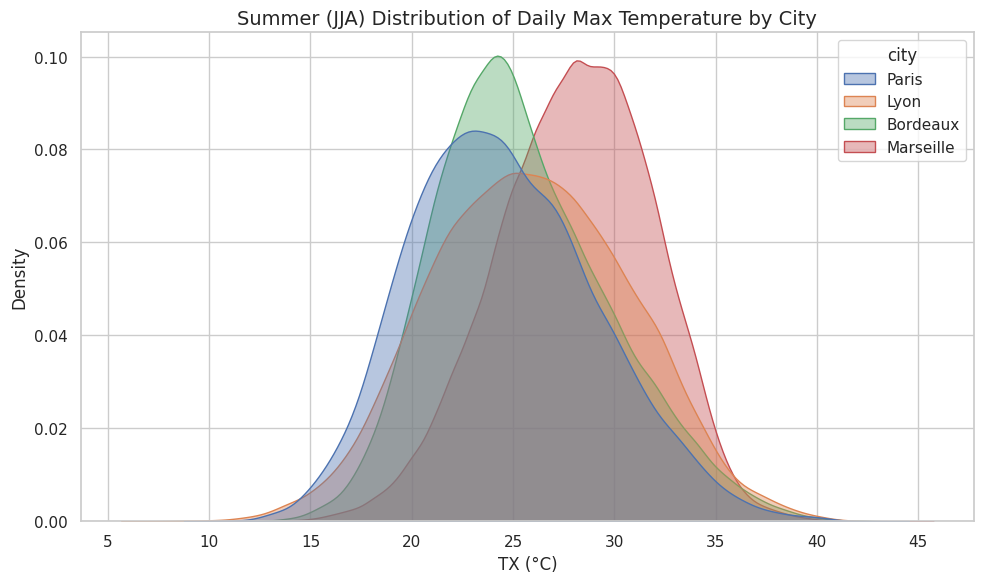

In [30]:
summer_data = data_tx[data_tx["is_summer"]]

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=summer_data,
    x="TX",
    hue="city",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("Summer (JJA) Distribution of Daily Max Temperature by City")
plt.xlabel("TX (°C)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

## 8. Summary and Conclusions (Step 1 – Data Mining & Visualization)

### 8.1. Key Findings

Based on the exploratory analysis of daily maximum temperature (`TX`) data for Paris, Lyon, Bordeaux, and Marseille:

1. **Data coverage and quality**
   - All four cities provide multi-decade daily temperature records from roughly the 1950s to the early 2020s.
   - Paris exhibits a higher fraction of missing values, whereas Bordeaux, Lyon, and Marseille have mostly complete data.
   - This should be considered when calibrating and validating any predictive model.

2. **Long-term warming and extreme heat**
   - Annual maximum temperatures and July mean temperatures show **clear upward trends** over time.
   - Statistical tests (Spearman correlations) confirm that these trends are **significant** in multiple cities.

3. **Seasonality of extreme heat**
   - Extreme heat days (TX > 35°C) are **strongly concentrated in July and August**.
   - Chi-square tests indicate that the occurrence of extreme events is **not independent of month**, confirming strong seasonality.

4. **Rising frequency of extremes**
   - The **share of extreme days per decade** has increased substantially, especially since the 1980s.
   - This pattern is observed across all cities, though the magnitude varies.

5. **City differences**
   - There are **systematic differences** in the distribution of TX and the frequency of extremes between cities, reflecting geographical and climatic factors (e.g., coastal vs. inland, latitude, altitude).

### 8.2. Implications for an Early Heat Alarm System

- An effective early heat alarm should:
  - **Focus on summer months**, especially July and August, while remaining aware of rare shoulder-season events.
  - Account for **city-specific baselines and thresholds**, using both absolute and relative definitions of extreme heat.
  - Incorporate the **observed upward trends** in baseline and extreme temperatures, rather than relying on mid-20th-century norms.


## Statistical Tests Used in This Notebook – Short Reference

This section provides a short, practice-oriented explanation of the main statistical tests used in the analysis.  
It is meant as a quick reference while working with the notebook.

---

### 1. Shapiro–Wilk Test (Normality Test)

**Goal:**  
Check whether a sample looks like it comes from a **normal (Gaussian) distribution**.

**Typical use in this project:**

- Test if daily maximum temperatures `TX` in a subset (e.g. summer vs. non-summer) are approximately normal.
- The result helps decide whether we can use **parametric tests** (like t-tests) or should prefer **non-parametric tests** (like Mann–Whitney U).

**Hypotheses:**

- H0 (null): The data **come from a normal distribution**.
- H1 (alternative): The data **do not** come from a normal distribution.

**Decision:**

- If p-value < 0.05 → **reject H0** → data are **not normal** (at least significantly different).
- If p-value ≥ 0.05 → **do not reject H0** → data are **not significantly different from normal**.

**Notes:**

- For very large samples, the test can become extremely sensitive and may detect tiny deviations.
- For real-world climate data, perfect normality is rare; the test mainly helps to **justify non-parametric tests**.

---

### 2. Mann–Whitney U Test (Wilcoxon Rank-Sum Test)

**Goal:**  
Compare **two independent groups** when the data are **not necessarily normal**.  
It tests whether one group tends to have **larger values** than the other.

**Typical use in this project:**

- Compare `TX` in **summer vs. non-summer** for one city.
- Investigate if **summer temperatures are statistically higher** than non-summer temperatures.

**Hypotheses (one-sided example):**

- H0 (null): The distribution of TX in summer is **not greater** than in non-summer (both distributions are equal or summer is lower).
- H1 (alternative): The distribution of TX in summer is **greater** than in non-summer.

**Decision:**

- If p-value < 0.05 (with alternative="greater") → reject H0 →  
  **summer temperatures are significantly higher** than non-summer temperatures.
- If p-value ≥ 0.05 → no significant evidence that summer > non-summer.

**Notes:**

- Non-parametric: uses **ranks** instead of raw values, so it is robust to outliers and non-normality.
- Requires independent observations and roughly similar distribution shapes.

---

### 3. Spearman Rank Correlation

**Goal:**  
Measure a **monotonic relationship** between two variables (e.g. increasing trend over time),  
without assuming a linear relationship or normal distribution.

**Typical use in this project:**

- Check for a trend between:
  - `year` and **annual maximum TX**
  - `year` and **July mean TX**
  - `decade` and **share of extreme days**
- Helps answer: *“Are extreme temperatures increasing over time?”*

**What it measures:**

- Spearman’s ρ (rho) is the **Pearson correlation on the ranks** of the data.
- ρ ranges from -1 to +1:
  - ρ ≈ +1 → strong **positive** monotonic association (as X increases, Y increases).
  - ρ ≈ -1 → strong **negative** monotonic association.
  - ρ ≈ 0 → **no monotonic** relationship.

**Hypotheses:**

- H0 (null): There is **no monotonic association** between the variables (ρ = 0).
- H1 (alternative): There **is** a monotonic association (ρ ≠ 0, or one-sided if we expect increase).

**Decision:**

- If p-value < 0.05 → reject H0 → significant monotonic trend.
- If p-value ≥ 0.05 → no significant monotonic trend detected.

**Why Spearman here?**

- Temperature and time series can be **non-linear** and **non-normal**.
- Spearman is more robust than Pearson when distributions are skewed or contain outliers.

---

### 4. Chi-Square Test of Independence

**Goal:**  
Test whether **two categorical variables** are **independent** or **associated**.

**Typical use in this project:**

- Is the occurrence of **extreme days (yes/no)** independent of the **month**?
- Is the occurrence of extreme days independent of **city** or **decade**?

We build a **contingency table**, e.g.:

| Month | Extreme = 0 | Extreme = 1 |
|-------|-------------|-------------|
| 1     |      a      |      b      |
| 2     |      c      |      d      |
| ...   |     ...     |     ...     |

**Hypotheses:**

- H0 (null): The two categorical variables are **independent**  
  (e.g. extreme events happen equally relative to the number of days in each month).
- H1 (alternative): The variables are **not independent**  
  (e.g. some months have **more extreme days** than expected).

**Decision:**

- If p-value < 0.05 → reject H0 → the variables are **associated** (e.g. month and extreme occurrence are linked).
- If p-value ≥ 0.05 → no significant association detected.

**Interpretation in our context:**

- A significant result for **month vs. extreme** means:  
  *“Extreme heat days are not evenly spread across months – they tend to cluster in certain months (e.g., July/August).”*
- For **city vs. extreme** or **decade vs. extreme share**, a significant result indicates **differences between cities or periods**.

---

### 5. General Notes on p-values and Significance

- A **p-value** is the probability of observing data **at least as extreme as ours**,  
  if the **null hypothesis were actually true**.
- A common significance level is **α = 0.05**:
  - p-value < 0.05 → **statistically significant** result.
  - p-value ≥ 0.05 → result is **not significant** (we do not reject H0).

**Important:**

- “Not significant” does **not** prove that there is no effect;  
  it only means that we do not have enough statistical evidence.
- Statistical significance ≠ practical relevance. In this project, we always combine:
  - **Visual inspection** (plots),
  - **Statistical tests**, and
  - **Business interpretation** (public health, risk, policy).

---